In [ ]:
!pip install wordcloud
!pip install gensim

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/velocitatem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/velocitatem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/velocitatem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
td = pd.read_csv('transformed_data.csv')

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

data = td.copy()
# Extracting event names
event_names = data['eventName'].dropna().astype(str)

# Applying TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(event_names)

# Applying NMF (Non-Negative Matrix Factorization) for topic modeling
n_topics = 5
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d:" % (topic_idx)] = " ".join([feature_names[i]
                                                          for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topic_dict

no_top_words = 10
topics = display_topics(nmf, tfidf_vectorizer.get_feature_names_out(), no_top_words)
topics


{'Topic 0:': 'hours office tuesday open careers consulting finance tech law communications',
 'Topic 1:': 'practice career cv optimization interview prep hr expert case finding',
 'Topic 2:': 'segovia swimming classes practice boxing women basketball men open club',
 'Topic 3:': 'football fun wednesdays fridays men tryouts vs madrid women sundays',
 'Topic 4:': 'social volleyball international impact relations development practice advanced tennis open'}

In [5]:
general_keywords = []
for topic in topics.values():
    general_keywords.extend(topic.split())
general_keywords = list(set(general_keywords))


In [6]:
tech_events = data[(data['clubName'].str.contains('tech', case=False)) | (data['eventName'].str.contains('tech', case=False)) | (data['eventName'].str.contains('robotics', case=False)) | (data['eventName'].str.contains('data', case=False)) | (data['eventName'].str.contains('ai', case=False))]
tech_event_names = tech_events['eventName'].dropna().astype(str)


In [7]:
from gensim.models import Word2Vec
import multiprocessing
# Preparing the data for Word2Vec
# Tokenizing the event names
tokenized_event_names = [name.lower().split() for name in tech_event_names]

# Creating a Word2Vec model
w2v_model = Word2Vec(tokenized_event_names,
                     min_count=1,  # Considering all words, even if they appear only once
                     window=5,     # Context window size
                     vector_size=100,  # Dimensionality of the word vectors
                     workers=multiprocessing.cpu_count())

# Finding keywords related to technology using the Word2Vec model
# The words 'technology' and 'tech' will be used as the seed words to find similar words
seed_words = ['technology', 'AI', 'data', 'cloud', 'blockchain', 'cybersecurity', 'machine', 'learning', 'IoT', 'internet', 'of', 'things', 'robotics', 'automation', 'virtual', 'reality', 'augmented', 'reality', '3D', 'printing', 'drones', 'wearables', 'quantum', 'computing', 'edge', 'computing', '5G', 'networks', 'smart', 'cities', 'smart', 'homes', 'smart', 'factories', 'smart', 'mobility', 'smart', 'retail', 'smart', 'agriculture', 'smart', 'healthcare', 'smart', 'energy', 'smart', 'utilities', 'smart', 'construction', 'smart', 'infrastructure', 'smart', 'logistics', 'smart', 'supply', 'chain', 'smart', 'manufacturing', 'smart', 'materials', 'smart', 'waste', 'management', 'smart', 'water', 'management', 'smart', 'air', 'management', 'smart', 'soil', 'management', 'smart', 'forestry', 'smart', 'mining', 'smart', 'ocean', 'management', 'smart', 'space', 'management', 'smart', 'environment', 'management', 'smart', 'sustainability', 'smart', 'resilience', 'smart', 'security', 'smart', 'privacy', 'smart', 'governance', 'smart', 'ethics', 'smart', 'regulation', 'smart', 'policies', 'smart', 'standards', 'smart', 'certifications', 'smart', 'compliance', 'smart', 'audits', 'smart', 'assurance', 'smart', 'verification', 'smart', 'validation', 'smart', 'testing', 'smart', 'monitoring', 'smart', 'control', 'smart', 'management', 'smart', 'optimization', 'smart', 'automation', 'smart', 'integration', 'smart', 'interoperability', 'smart', 'collaboration', 'smart', 'coordination', 'smart', 'communication', 'smart', 'engagement', 'smart', 'participation', 'smart', 'inclusion', 'smart', 'accessibility', 'smart', 'equity', 'smart', 'diversity', 'smart', 'inclusion', 'smart', 'engagement', 'smart', 'participation', 'smart', 'empowerment', 'smart', 'education', 'smart', 'tech']
tech_keywords = {}

for word in seed_words:
    # For each seed word, find similar words based on the model
    try:
        similar_words = w2v_model.wv.most_similar(word, topn=5)
        tech_keywords[word] = [w[0] for w in similar_words]
    except KeyError:
        # If the seed word is not in the vocabulary
        tech_keywords[word] = []


# remove empty:
# remove stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tech_keywords = {k: [word for word in v if word not in stop_words] for k, v in tech_keywords.items()}
tech_keywords = {k: v for k, v in tech_keywords.items() if v}
tech_keywords


{'technology': ['-', '&'],
 'data': ['ie', 'training', 'conversation'],
 'cybersecurity': ['mit', 'virtual', '45', 'ceo', 'royal'],
 'of': ['-', 'ie'],
 'robotics': ['-', '&', 'eva'],
 'virtual': ['-', 'marcus', 'conversation'],
 'quantum': ['71', '[segovia]', 'workshop', 'best-selling', '[madrid]'],
 'computing': ['life', 'energy,', 'pressure:', 'maintaining', 'student’s'],
 'mobility': ['volunteerism', 'author,', 'forum', 'technology'],
 'retail': ['experience', 'conversation', 'future'],
 'management': ['roles', 'yoga', 'opening', 'merge', 'get'],
 'water': ['spain', 'driver', 'cultural', 'mathematics'],
 'space': ['retail', 'shapelets', 'partnerships', 'grads', 'ai:'],
 'sustainability': ['marcus', '-', 'ie'],
 'regulation': ['vr', 'library', 'tutoring', 'driver', 'sustainability'],
 'integration': ['estate,', 'arab', 'science', 'dr.', 'speaker'],
 'communication': ['finance,', 'transform', 'roles', 'finance', 'townhall'],
 'education': ['goods,', 'techniques', 'marcus', 'expert', 

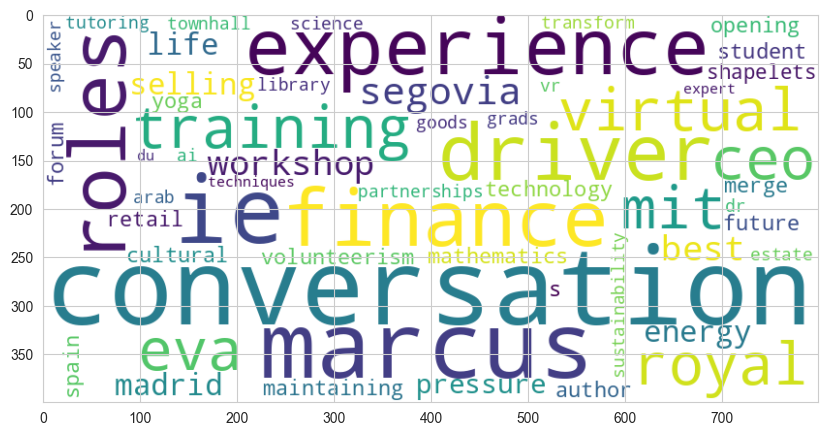

In [8]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(
    ' '.join([word for words in tech_keywords.values() for word in words]))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")

<AxesSubplot: >

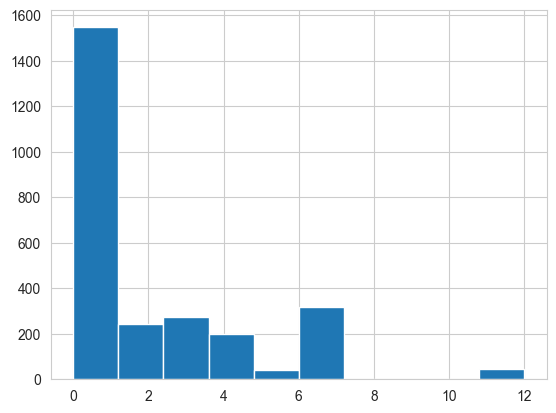

In [9]:
# plot for all events, use of general keywords for previous generations wiht attendance:
# create a count of keywords from general_keywords in event names
td['general_keywords'] = td['eventName'].apply(lambda x: sum([1 for word in general_keywords if word in x.lower()]))
td['general_keywords'].hist()

In [10]:
# correlation between general_keywords and eventAttendees
td[['general_keywords', 'eventAttendees']].corr()

,general_keywords,eventAttendees
general_keywords,1.00000,-0.15162
eventAttendees,-0.15162,1.00000


Text(0.5, 1.0, 'Use of General Keywords vs. Event Attendees')

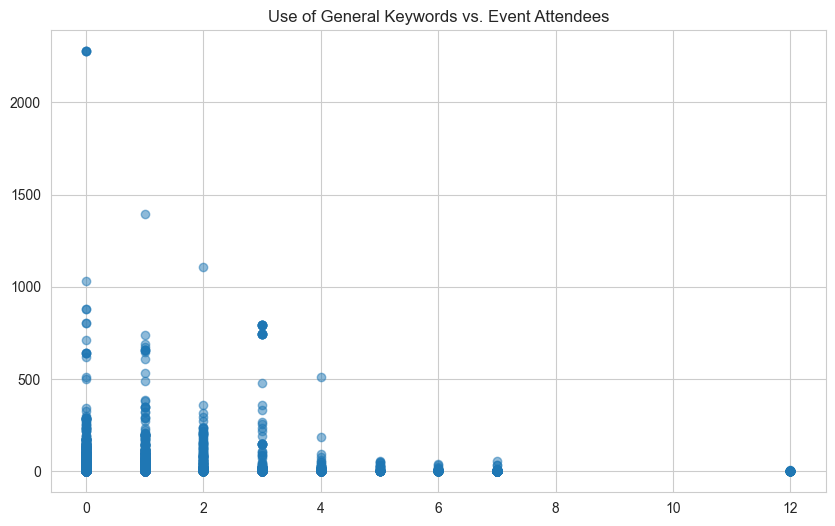

In [11]:
# plot for all events, use of tech keywords for previous generations wiht attendance. plto it:
plt.figure(figsize=(10, 6))  # scatter the plot
plt.scatter(td['general_keywords'], td['eventAttendees'], alpha=0.5)
plt.title('Use of General Keywords vs. Event Attendees')

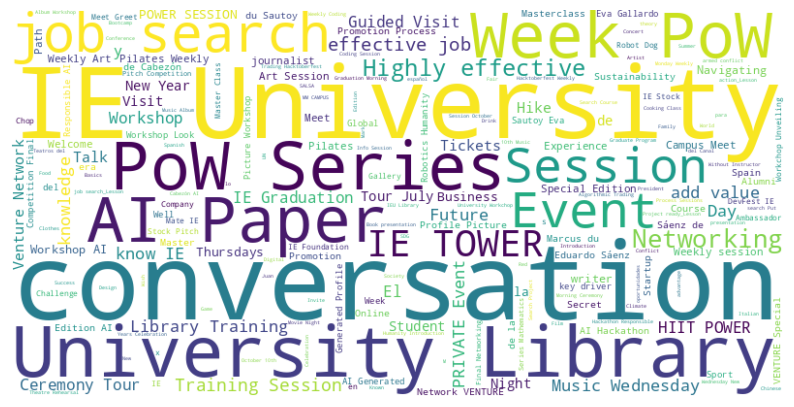

In [12]:
# seems like there is a -0.25 correlation between the two, which is not very strong, what words do the 0 general_keywords events contain?
top_rare_kw = td[td['general_keywords'] == 0]['eventName']
# use wordcloud to visualize the most common words in the event names
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(
    ' '.join(top_rare_kw))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [13]:
top_keywords = []  # from rare events
# using sklearn as before
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

# Extracting event names
event_names = top_rare_kw.dropna().astype(str)

# Applying TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(event_names)

# Applying NMF (Non-Negative Matrix Factorization) for topic modeling
n_topics = 5
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)


def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d:" % (topic_idx)] = " ".join([feature_names[i]
                                                          for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topic_dict


no_top_words = 10
topics = display_topics(nmf, tfidf_vectorizer.get_feature_names_out(), no_top_words)
topics

{'Topic 0:': 'pow week paper ai series hackathon future generated picture profile',
 'Topic 1:': 'university library training knowledge value add know session devfest ieu',
 'Topic 2:': 'session weekly pilates hiit power art thursdays mm31 hacktoberfest october',
 'Topic 3:': 'workshop music tower wednesday album mate look meet campus profile',
 'Topic 4:': 'job search effective highly networking action_lesson theory search_lesson advantage course'}

In [15]:
import markovify

# combine all event namesimport markovify

# Combine all event names into a single string
# get those with least general_keywords and most attendees
all_event_names = ' '.join(top_rare_kw)
# add tech events to it
all_event_names += ' '.join(tech_event_names)
# Build the Markov chain model
text_model = markovify.Text(all_event_names, state_size=2)
inputs = ['idea', 'competition', 'hackathon', 'thon']  # because they might not be present in the event names
synonyms = []
from nltk.corpus import wordnet

for word in inputs:
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
inputs.extend(synonyms)
inputs = list(set(inputs))

# Generate event names until one includes the input words
print(inputs)


['hackathon', 'rivalry', 'contender', 'idea', 'contest', 'musical_theme', 'challenger', 'mind', 'thought', 'approximation', 'melodic_theme', 'estimate', 'rival', 'thon', 'competitor', 'theme', 'competition', 'estimation', 'contention']


In [16]:
# Generate event names:
for _ in range(10):
    event_name = text_model.make_sentence()
    print(event_name)

Japan Embassy at IE Tower Escape Box en A Coruña - IE Tower Escape Box en A Coruña - IE Startup Experience ENVISIONING YOUR FUTURE TO SUCCESS!
RAVIOLI BLIND TASTING COMPETITION @ RELLENO Music Wednesday: Celebramos la Hispanidad!
VR SPORTS CLASS Session 0 Music Wednesday at the IE Tower!
Winter Clothes Drive Clothes Collection WINTER GATHERING 2023 Authentic Connection IE University Library and add value to your knowledge!
ScholarSenate Conference: 1st Edition Flutter Workshop: Learning the Basics IE Chinese New Year IE University Library and add value to your knowledge!
None
Master Class: SALSA Y BACHATA IE University Library and add value to your knowledge!
None
VR SPORTS CLASS Session 0 Music Wednesday - New Years Celebration!
RAVIOLI BLIND TASTING COMPETITION @ RELLENO Music Wednesday: Celebramos la Hispanidad!
